# Лабораторная №1 по NLP. Создание полносвязных нейронных сетей для решения задач **регрессии** и **классификации**

## Иморты

In [292]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [293]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Задача регрессии

In [294]:
data_reg = pd.read_csv('mumbai_houses_task_filtred.csv')
data_reg

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,parking,furnished_status,lift,type_of_building
0,22400000,629,19.032800,72.896357,2,2,0,0,1,0,0,0,0
1,35000000,974,19.032800,72.896357,3,2,0,0,1,0,0,0,0
2,31700000,968,19.085600,72.909277,3,3,0,0,1,0,0,0,0
3,18700000,629,19.155756,72.846862,2,2,2,1,1,2,0,2,0
4,13500000,1090,19.177555,72.849887,2,2,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,19500000,810,19.138320,72.810020,2,2,0,1,0,0,2,0,0
6233,22000000,1400,19.221920,72.854250,3,3,1,1,0,1,0,1,0
6234,20000000,750,19.144320,72.824111,2,2,0,1,0,0,0,0,0
6235,11000000,700,19.047201,72.872225,2,2,0,1,0,0,1,0,0


In [295]:
Q1 = data_reg['price'].quantile(0.25)
Q3 = data_reg['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = data_reg[(data_reg['price'] >= lower_bound) & (data_reg['price'] <= upper_bound)]

In [296]:
filtered_df['price'].describe()

count    5.720000e+03
mean     2.046298e+07
std      1.157538e+07
min      1.500000e+06
25%      1.250000e+07
50%      1.800000e+07
75%      2.700000e+07
max      5.550000e+07
Name: price, dtype: float64

Датасет полностью предобработан, но в нем присутствуют идентичные друг другу признаки, поэтому они будут удалены из датасета.

In [297]:
mask_dup = filtered_df.T.duplicated(keep='first')
drop_cols = filtered_df.columns[mask_dup].tolist()
filtered_df = filtered_df.loc[:, ~mask_dup]

print("удалены:", drop_cols)
filtered_df

удалены: ['parking', 'lift']


,price,area,latitude,longitude,bedrooms,bathrooms,balcony,status,neworold,furnished_status,type_of_building
0,22400000,629,19.032800,72.896357,2,2,0,0,1,0,0
1,35000000,974,19.032800,72.896357,3,2,0,0,1,0,0
2,31700000,968,19.085600,72.909277,3,3,0,0,1,0,0
3,18700000,629,19.155756,72.846862,2,2,2,1,1,0,0
4,13500000,1090,19.177555,72.849887,2,2,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6232,19500000,810,19.138320,72.810020,2,2,0,1,0,2,0
6233,22000000,1400,19.221920,72.854250,3,3,1,1,0,0,0
6234,20000000,750,19.144320,72.824111,2,2,0,1,0,0,0
6235,11000000,700,19.047201,72.872225,2,2,0,1,0,1,0


In [298]:
X_reg = filtered_df.drop(columns=['price']).to_numpy()
y_reg = filtered_df['price'].to_numpy()
y_reg = y_reg.reshape(-1, 1)
# y_reg = np.log1p(y_reg)

Также у целевого признака очень скошено распределение, поэтому применю логарифмирование + скалирование

In [299]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.05)
X_reg_train.shape, X_reg_test.shape, y_reg_train.shape, y_reg_test.shape

((5434, 10), (286, 10), (5434, 1), (286, 1))

In [300]:
train_reg_ds = TensorDataset(torch.from_numpy(X_reg_train).type(torch.float32), torch.from_numpy(y_reg_train).type(torch.float32)) 
train_reg_dl = DataLoader(train_reg_ds, batch_size=256, shuffle=True) 
x_reg, y_reg = next(iter(train_reg_dl)) 
x_reg.shape, y_reg.shape

(torch.Size([256, 10]), torch.Size([256, 1]))

In [301]:
test_reg_ds = TensorDataset(torch.from_numpy(X_reg_test), torch.from_numpy(y_reg_test)) 
test_reg_dl = DataLoader(test_reg_ds, batch_size=256, shuffle=True)

### Создание модели

In [302]:
class MyRegressionModel(nn.Module): 
    def __init__(self, input_size: int): 
        super(MyRegressionModel, self).__init__() 
        self.first_reg_linear = nn.Linear(in_features=input_size, out_features=32) 
        self.first_reg_relu = nn.ReLU() 
        self.second_reg_linear = nn.Linear(in_features=32, out_features=64) 
        self.second_reg_relu = nn.ReLU() 
        self.third_reg_linear = nn.Linear(in_features=64, out_features=32) 
        self.third_reg_relu = nn.ReLU() 
        self.fourth_reg_linear = nn.Linear(in_features=32, out_features=1)
        # self.fourth_reg_relu = nn.ReLU() 
        # self.fifth_reg_linear = nn.Linear(in_features=16, out_features=1)
    def forward(self, x): 
        y = self.first_reg_linear(x) 
        y = self.first_reg_relu(y) 
        y = self.second_reg_linear(y) 
        y = self.second_reg_relu(y) 
        y = self.third_reg_linear(y) 
        y = self.third_reg_relu(y) 
        y = self.fourth_reg_linear(y)
        # y = self.fourth_reg_relu(y)
        # y = self.fifth_reg_linear(y)
        return y

In [303]:
model_reg = MyRegressionModel(input_size=x_reg.shape[1]).to(device)
model_reg

MyRegressionModel(
  (first_reg_linear): Linear(in_features=10, out_features=32, bias=True)
  (first_reg_relu): ReLU()
  (second_reg_linear): Linear(in_features=32, out_features=64, bias=True)
  (second_reg_relu): ReLU()
  (third_reg_linear): Linear(in_features=64, out_features=32, bias=True)
  (third_reg_relu): ReLU()
  (fourth_reg_linear): Linear(in_features=32, out_features=1, bias=True)
)

In [304]:
loss_reg = nn.MSELoss() 
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=0.0005)

In [305]:
epochs_reg = 100
for epoch_reg in range(epochs_reg): 
    for x_reg_b, y_reg_b in train_reg_dl:
        x_reg_b, y_reg_b = x_reg_b.to(device), y_reg_b.to(device) 
        outputs = model_reg(x_reg_b) 
        loss_value = loss_reg(outputs, y_reg_b) 
        loss_value.backward() 
        optimizer_reg.step() 
        optimizer_reg.zero_grad() 
    print(f'Эпоха {epoch_reg + 1}, Значение функции потерь: {loss_value.item()}')

Эпоха 1, Значение функции потерь: 676114959695872.0
Эпоха 2, Значение функции потерь: 585929639067648.0
Эпоха 3, Значение функции потерь: 445496355192832.0
Эпоха 4, Значение функции потерь: 719518825447424.0
Эпоха 5, Значение функции потерь: 348348221489152.0
Эпоха 6, Значение функции потерь: 365147818295296.0
Эпоха 7, Значение функции потерь: 550536759738368.0
Эпоха 8, Значение функции потерь: 529166713749504.0
Эпоха 9, Значение функции потерь: 519525753683968.0
Эпоха 10, Значение функции потерь: 439667447037952.0
Эпоха 11, Значение функции потерь: 480448228622336.0
Эпоха 12, Значение функции потерь: 523391828230144.0
Эпоха 13, Значение функции потерь: 507041089060864.0
Эпоха 14, Значение функции потерь: 491199001526272.0
Эпоха 15, Значение функции потерь: 694876987457536.0
Эпоха 16, Значение функции потерь: 566636713082880.0
Эпоха 17, Значение функции потерь: 607046651084800.0
Эпоха 18, Значение функции потерь: 494770535268352.0
Эпоха 19, Значение функции потерь: 567284045185024.0
Эп

In [306]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model_reg(torch.from_numpy(X_reg_test).to(device).type(torch.float32)).cpu()


y_pred_orig = y_pred.detach()

r2 = r2_score(y_reg_test, y_pred_orig)
rmse = mean_squared_error(y_reg_test, y_pred_orig)
print("R2 (orig):", r2)
print("RMSE (orig):", rmse)

R2 (orig): 0.19545555114746094
RMSE (orig): 110658943188992.0


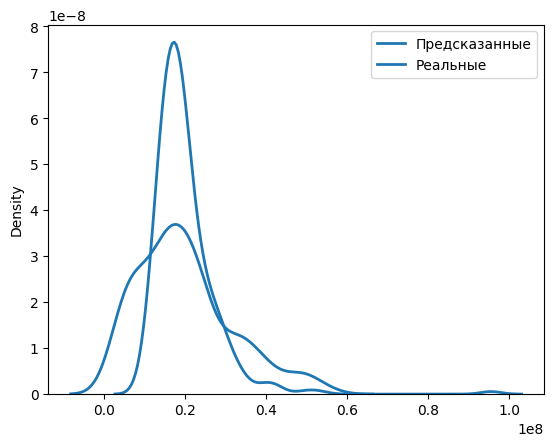

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(y_pred_orig, color='red', label='Предсказанные', linewidth=2)
sns.kdeplot(y_reg_test, color='green', label='Реальные', linewidth=2)
plt.legend()
plt.show()